In [1]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import anndata

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import pandas as pd


# Download embeddings from S3 or Google Drive and put it in `../data`

Both Anndata objects have the same samples—namely, the EGFR-related samples. Controls included.

- `rxrx_adata` represents simply the embeddings given to us by Recursion. 
- `cp_adata` represents a CellProfiler pipeline run on the same samples.

In [ ]:
# Read the data
rxrx_adata = anndata.read_h5ad("../data/rxrx3_embeddings.h5ad")
print(rxrx_adata.shape)  # 128 dimensions

cp_adata = anndata.read_h5ad("../data/rxrx3_cellprofiler.h5ad")
print(cp_adata.shape)  # 6.5k dimensions, many low-variance, correlated, bad, etc.

# Reformat treatment_column slightly
rxrx_adata.obs['treatment'] = rxrx_adata.obs['treatment'].str.replace('EGFR_guide_\d+', 'EGFR_KO', regex=True)
cp_adata.obs['treatment'] = cp_adata.obs['treatment'].str.replace('EGFR_guide_\d+', 'EGFR_KO', regex=True)

rxrx_adata.obs['log10_concentration'] = rxrx_adata.obs['concentration'].apply(lambda x: np.log10(x))
cp_adata.obs['log10_concentration'] = cp_adata.obs['concentration'].apply(lambda x: np.log10(x))

# Filter for just EGFR-KO related samples
from utils import get_crispr_perturbations
crispr_rxrx_adata = get_crispr_perturbations(rxrx_adata)
crispr_cp_adata = get_crispr_perturbations(cp_adata)

crispr_cp_adata
crispr_rxrx_adata

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd


class NaNFilter(BaseEstimator, TransformerMixin):
    """
    Remove columns with too many NaN values and fill remaining NaNs with 0.
    """
    def __init__(self, nan_threshold=0.5):
        self.nan_threshold = nan_threshold
        self.valid_columns_ = None

    def fit(self, X, y=None):
        # Compute fraction of NaNs per column
        nan_fraction = np.isnan(X).mean(axis=0)
        self.valid_columns_ = nan_fraction < self.nan_threshold
        return self

    def transform(self, X, y=None):
        # Select valid columns and fill remaining NaNs with 0
        X_filtered = X[:, self.valid_columns_]
        imputer = SimpleImputer(strategy="constant", fill_value=0)
        return imputer.fit_transform(X_filtered)


class CorrelationFilter(BaseEstimator, TransformerMixin):
    """
    Custom transformer to remove highly correlated features from a dataframe.
    """
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_keep_ = None

    def fit(self, X, y=None):
        # Compute the correlation matrix
        corr_matrix = pd.DataFrame(X).corr().abs()
        upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        self.to_keep_ = ~corr_matrix.where(upper_triangle).apply(
            lambda x: any(x > self.threshold), axis=0
        )
        return self

    def transform(self, X, y=None):
        # Select only the features to keep
        return X[:, self.to_keep_.values] if isinstance(X, np.ndarray) else X.loc[:, self.to_keep_]


def create_feature_selection_pipeline(var_threshold=0.01, corr_threshold=0.9, nan_threshold=0.7, k=100):
    """
    Create a sklearn pipeline for feature selection with NaN filter, variance filter,
    correlation filter, and SelectKBest.
    
    Parameters:
        var_threshold (float): Threshold for variance filtering.
        corr_threshold (float): Threshold for correlation filtering.
        nan_threshold (float): Maximum fraction of NaNs allowed per column.
        k (int): Number of features to select with SelectKBest.
    
    Returns:
        Pipeline: A sklearn pipeline object.
    """
    return Pipeline([
        ("nan_filter", NaNFilter(nan_threshold=nan_threshold)),
        ("variance_filter", VarianceThreshold(threshold=var_threshold)),
        ("correlation_filter", CorrelationFilter(threshold=corr_threshold)),
        ("select_k_best", SelectKBest(score_func=f_classif, k=k))
    ])


In [4]:
def apply_feature_selection_pipeline(adata, pipeline, target):
    """
    Apply a sklearn feature selection pipeline to an AnnData object.

    Parameters:
        adata (AnnData): Input AnnData object.
        pipeline (Pipeline): Sklearn feature selection pipeline.
        target (str): Column name in adata.obs containing target labels.

    Returns:
        AnnData: New AnnData object with selected features.
    """
    # Ensure target column exists
    if target not in adata.obs.columns:
        raise ValueError(f"Target column '{target}' not found in adata.obs.")

    # Extract X (features) and y (labels)
    X = adata.X
    y = adata.obs[target].values

    # Fit the pipeline and transform X
    X_selected = pipeline.fit_transform(X, y)

    # Get selected feature indices and update adata.var
    selected_features = pipeline.named_steps["select_k_best"].get_support(indices=True)
    selected_var = adata.var.iloc[selected_features].copy()

    # Create a new AnnData object with the selected features
    adata_selected = adata[:, selected_features].copy()

    # Update X and var
    adata_selected.X = X_selected
    adata_selected.var = selected_var

    return adata_selected


In [ ]:
crispr_cp_adata_selected = apply_feature_selection_pipeline(crispr_cp_adata, create_feature_selection_pipeline(), target="treatment")
crispr_cp_adata_selected
# crispr_rxrx_adata_selected = apply_feature_selection_pipeline(crispr_rxrx_adata, create_feature_selection_pipeline(), target="treatment")

In [ ]:
import pandas as pd
import numpy as np


def inspect_features(adata):
    """
    Generate a summary table with variance, correlation, and NaN fraction for each feature.

    Parameters:
        adata (AnnData): Input AnnData object.

    Returns:
        pd.DataFrame: Table summarizing feature-level statistics.
    """
    # compute variance
    feature_variance = np.nanvar(adata.X, axis=0)

    # compute NaN fraction
    nan_fraction = np.isnan(adata.X).mean(axis=0)

    # compute absolute correlations
    corr_matrix = pd.DataFrame(adata.X).corr().abs()
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    max_corr = corr_matrix.where(upper_triangle).max()

    # combine all metrics into a dataframe
    feature_summary = pd.DataFrame({
        "feature_name": adata.var_names,
        "variance": feature_variance,
        "nan_fraction": nan_fraction,
        "max_correlation": max_corr.values
    })

    # sort by nan_fraction and variance for easier inspection
    feature_summary = feature_summary.sort_values(by=["nan_fraction", "variance"], ascending=[True, False])

    return feature_summary.reset_index(drop=True)


In [ ]:
feature_summary = inspect_features(crispr_cp_adata)

In [100]:
import re
feature_summary['compartment'] = feature_summary['feature_name'].str.split('_').str[0]
feature_summary['statistic'] = feature_summary['feature_name'].str.split('_').str[-1]


# Assuming you have a DataFrame named feature_summary with a column 'feature_name'
feature_summary['compartment'] = feature_summary['feature_name'].str.split('_').str[0]
feature_summary['statistic'] = feature_summary['feature_name'].str.split('_').str[-1]
feature_summary['middle'] = feature_summary['feature_name'].str.extract(r'^[^_]+_(.+)_[^_]+$')[0]

# Remove middles that match with a string in this list
remove = ['BoxMaximum', 'BoxMinimum', 'Location_Center']
feature_summary = feature_summary.dropna(subset=['max_correlation']).query("max_correlation < 0.9").sort_values(by="variance", ascending=False)
# Create a regex pattern from the list of terms to remove
pattern = '|'.join(re.escape(term) for term in remove)

# Filter out rows where 'middle' contains any term in the 'remove' list
feature_summary = feature_summary.dropna(subset=['max_correlation']) \
                                  .query("max_correlation < 0.9") \
                                  .sort_values(by="variance", ascending=False)

feature_summary = feature_summary[~feature_summary['middle'].str.contains(pattern, na=False)]

feature_summary['middle'].unique()

array(['AreaShape_Area', 'AreaShape',
       'Intensity_IntegratedIntensity_ConA',
       'Intensity_IntegratedIntensity',
       'Intensity_IntegratedIntensity_DNA',
       'Intensity_IntegratedIntensity_Actin', 'AreaShape_Perimeter',
       'AreaShape_BoundingBoxArea', 'Intensity_IntegratedIntensity_WGA',
       'Neighbors_AngleBetweenNeighbors',
       'Neighbors_FirstClosestDistance', 'AreaShape_Orientation',
       'Neighbors_AngleBetweenNeighbors_50', 'AreaShape_MajorAxisLength',
       'AreaShape_ConvexArea', 'Intensity_IntegratedIntensityEdge_ConA',
       'Intensity_IntegratedIntensityEdge', 'Children_Nucleoli',
       'Mean_MitoObjects_Distance_Centroid', 'Neighbors_PercentTouching',
       'Distance_Centroid_Cells', 'Distance_Centroid_Nuclei',
       'Intensity_IntegratedIntensityEdge_Mito',
       'AreaShape_EquivalentDiameter', 'Mean_Nucleoli_Distance_Centroid',
       'Children_MitoObjects_Count',
       'Mean_MitoObjects_Distance_Centroid_Cells', 'Children_MitoObjects',


In [125]:
# Filter out features with 100% correlation or a NaN
fs = feature_summary.dropna(subset=['max_correlation']).query("max_correlation < 0.9").sort_values(by="variance", ascending=False).copy()
fs

,feature_name,variance,nan_fraction,max_correlation,compartment,statistic,middle
65,cells_AreaShape_Area_std,7.849483e+03,0.003891,0.659123,cells,std,AreaShape_Area
195,nuclei_AreaShape_Area_std,3.567668e+03,0.003891,0.709058,nuclei,std,AreaShape_Area
353,cells_AreaShape_Area_mad,1.795217e+03,0.003891,0.830121,cells,mad,AreaShape_Area
475,nuclei_AreaShape_Area,9.281371e+02,0.003891,0.751335,nuclei,Area,AreaShape
658,cells_Intensity_IntegratedIntensity_ConA_std,4.658010e+02,0.003891,0.876761,cells,std,Intensity_IntegratedIntensity_ConA
...,...,...,...,...,...,...,...
5660,cells_Intensity_MinIntensityEdge_ConA_mad,3.439390e-10,0.003891,0.618841,cells,mad,Intensity_MinIntensityEdge_ConA
5663,nucleoli_Correlation_Manders_ConA_RNA,2.084958e-10,0.003891,0.583815,nucleoli,RNA,Correlation_Manders_ConA
5665,cytoplasm_Intensity_MinIntensityEdge_ConA_mad,4.320111e-11,0.003891,0.574570,cytoplasm,mad,Intensity_MinIntensityEdge_ConA
6329,golgi_AreaShape_FormFactor,NaN,0.003891,0.892125,golgi,FormFactor,AreaShape


In [195]:
fs['middle'].value_counts()

AreaShape                               39
Intensity_MassDisplacement              22
Correlation_Correlation_DNA             17
Correlation_Manders_Actin               15
AreaShape_Extent                        15
                                        ..
Correlation_K_RNA_WGA                    1
Correlation_RWC_WGA_Mito                 1
Intensity_StdIntensity_Mito              1
Correlation_Manders_Actin_ConA           1
Intensity_LowerQuartileIntensity_RNA     1
Name: middle, Length: 233, dtype: int64

In [86]:
from utils import plot_histograms_by_group, plot_boxplots_by_group

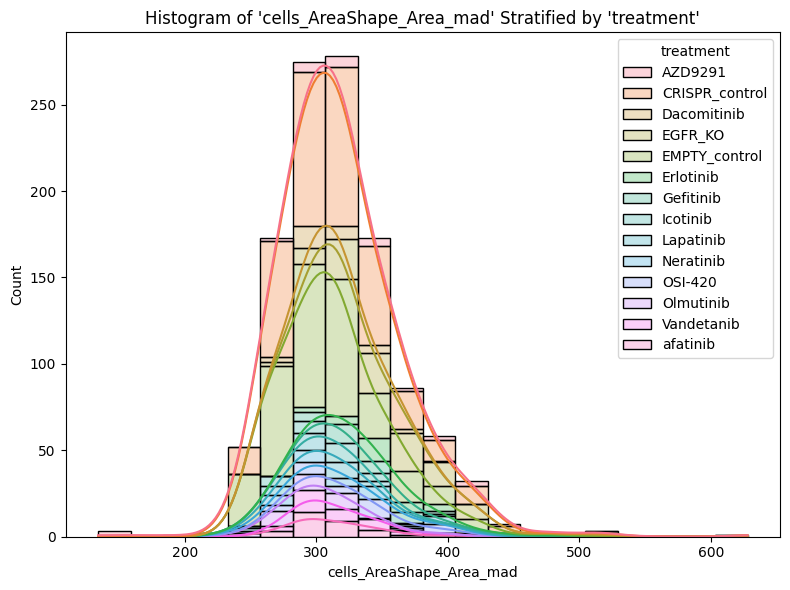

In [102]:
plot_histograms_by_group(
    # crispr_cp_adata,
    adata=cp_adata,
    var_names=["cells_AreaShape_Area_mad"],
    obs_names="treatment",
    bins=20,
    legend_loc="upper left"
)


In [ ]:
for concentration in cp_adata.obs['concentration'].unique():
    _adata = cp_adata.copy()
    _adata = _adata[(_adata.obs['concentration'] == concentration)]
    
    print(f"Concentration: {concentration}")
    plot_boxplots_by_group(_adata, ["cells_AreaShape_Area_std"], "treatment")

In [ ]:
sns.kdeplot(data=cp_adata.to_df(), x="cells_AreaShape_Area_std", hue=cp_adata.obs['treatment'], common_norm=False)
plt.show()


/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-pac

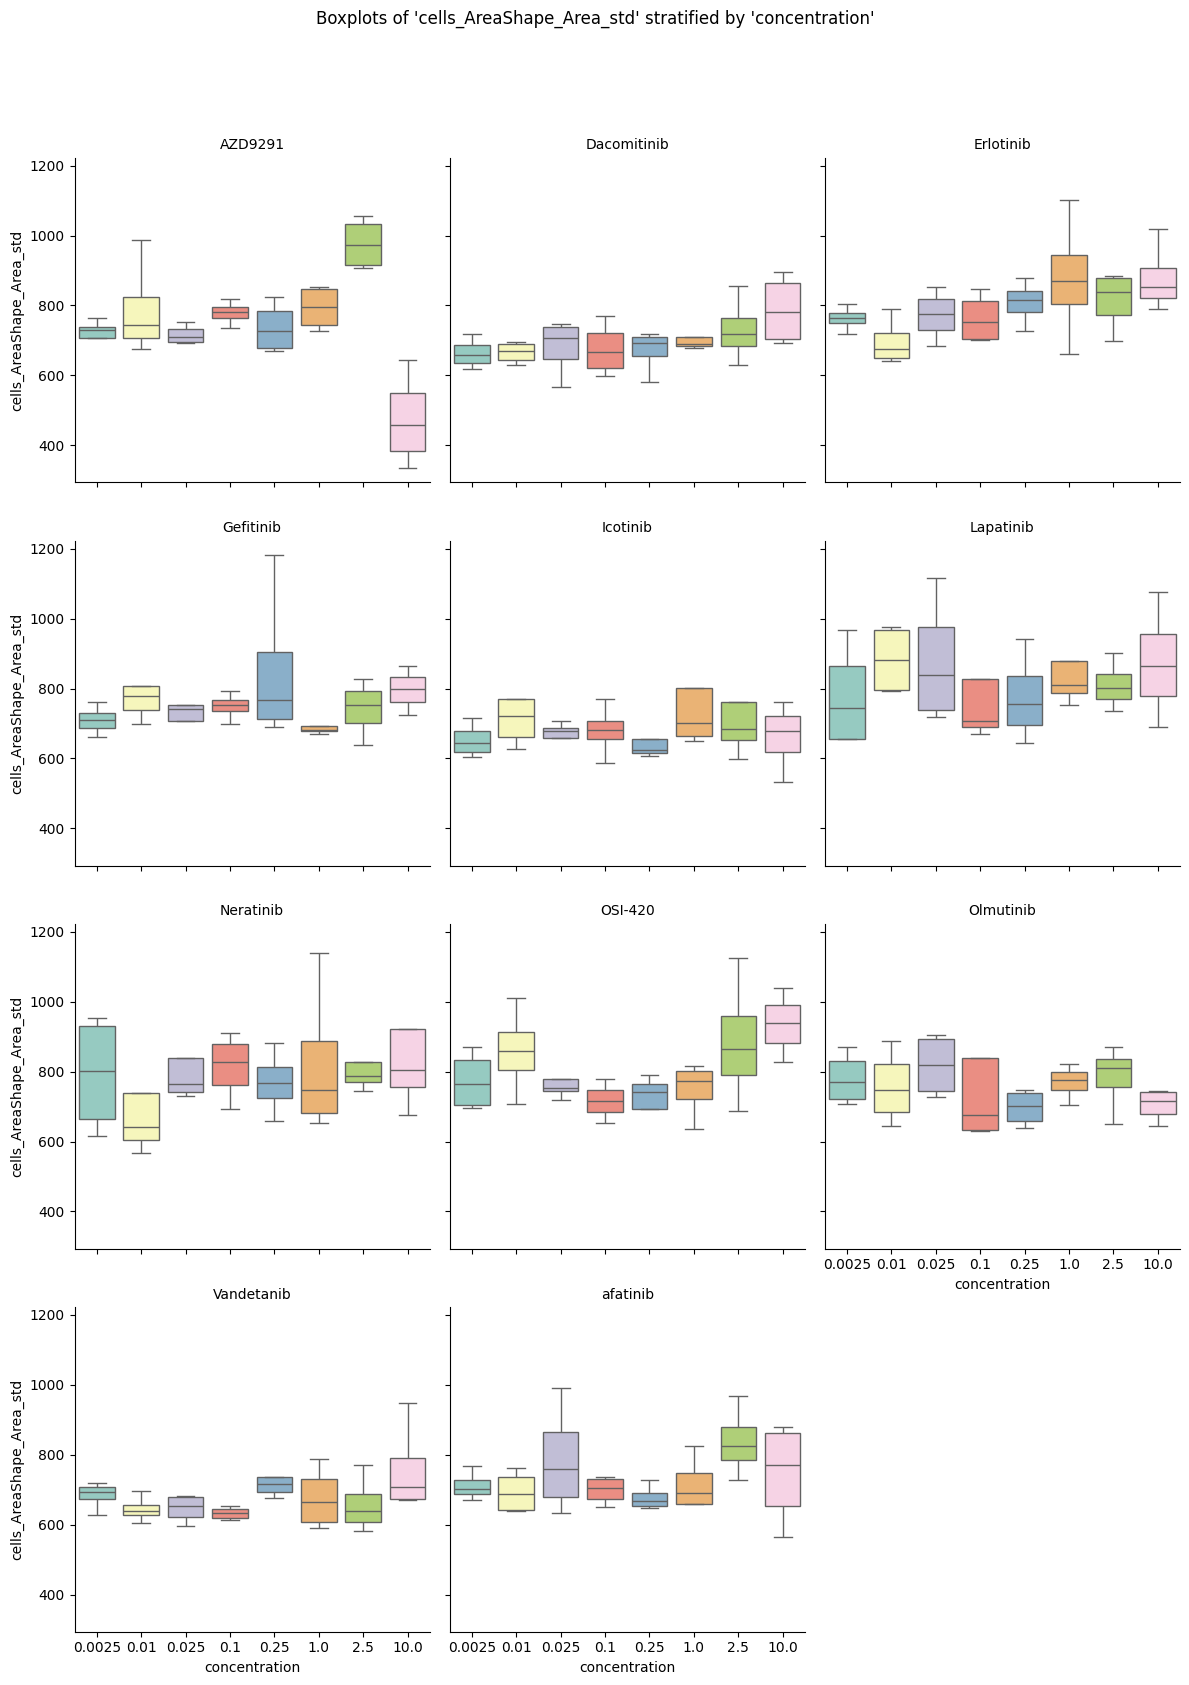

/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-pac

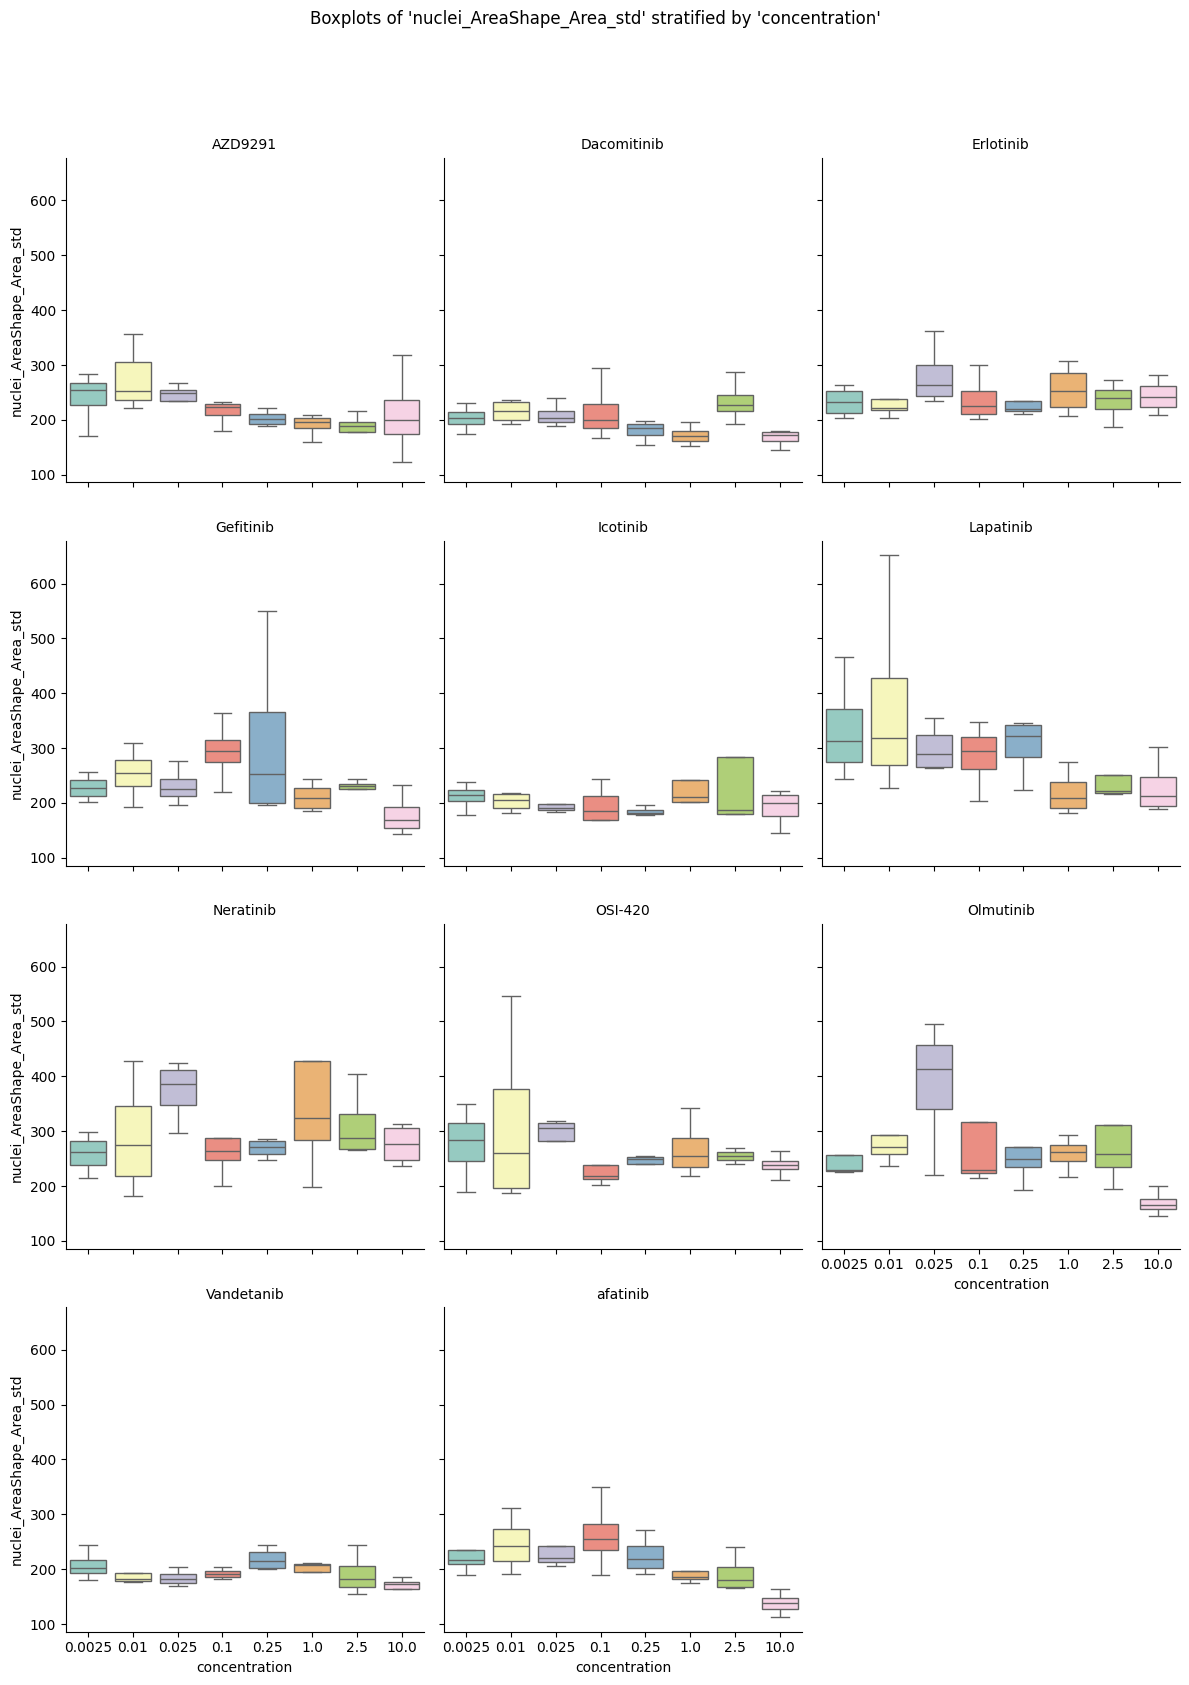

/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-pac

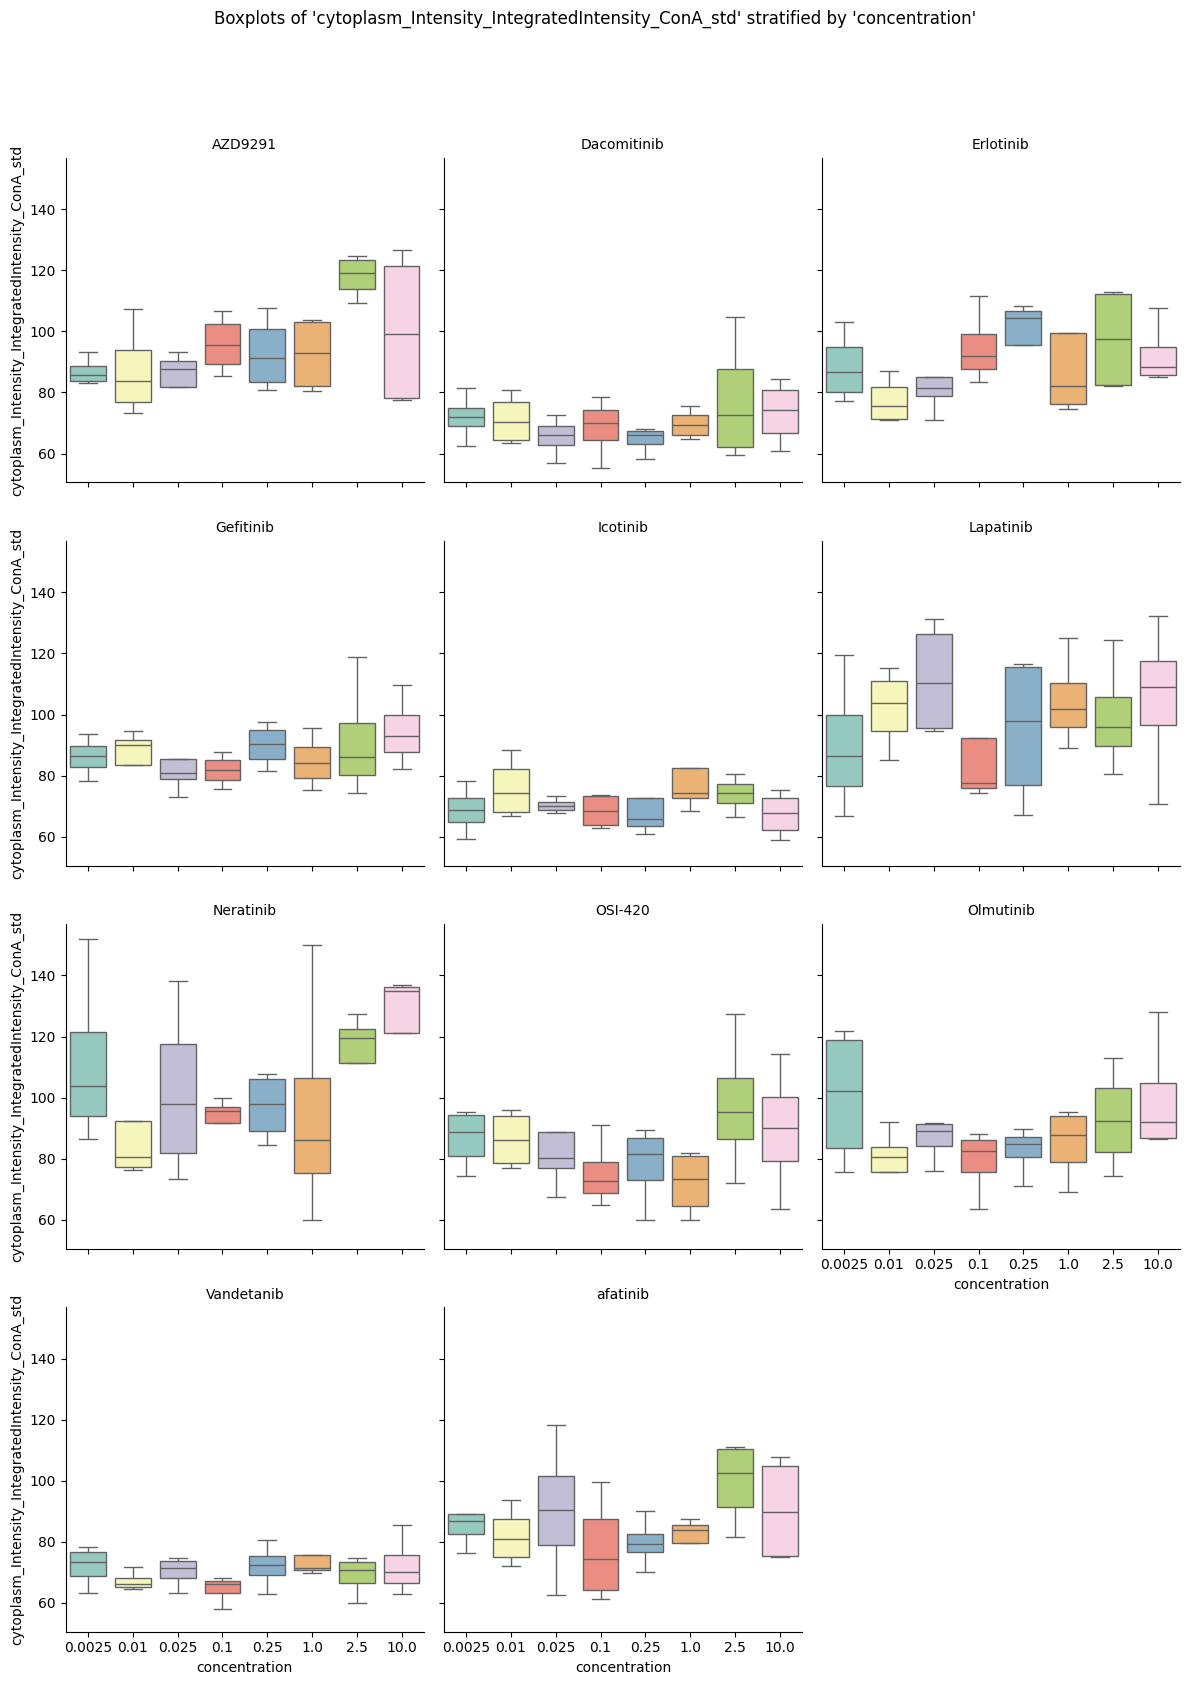

/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-pac

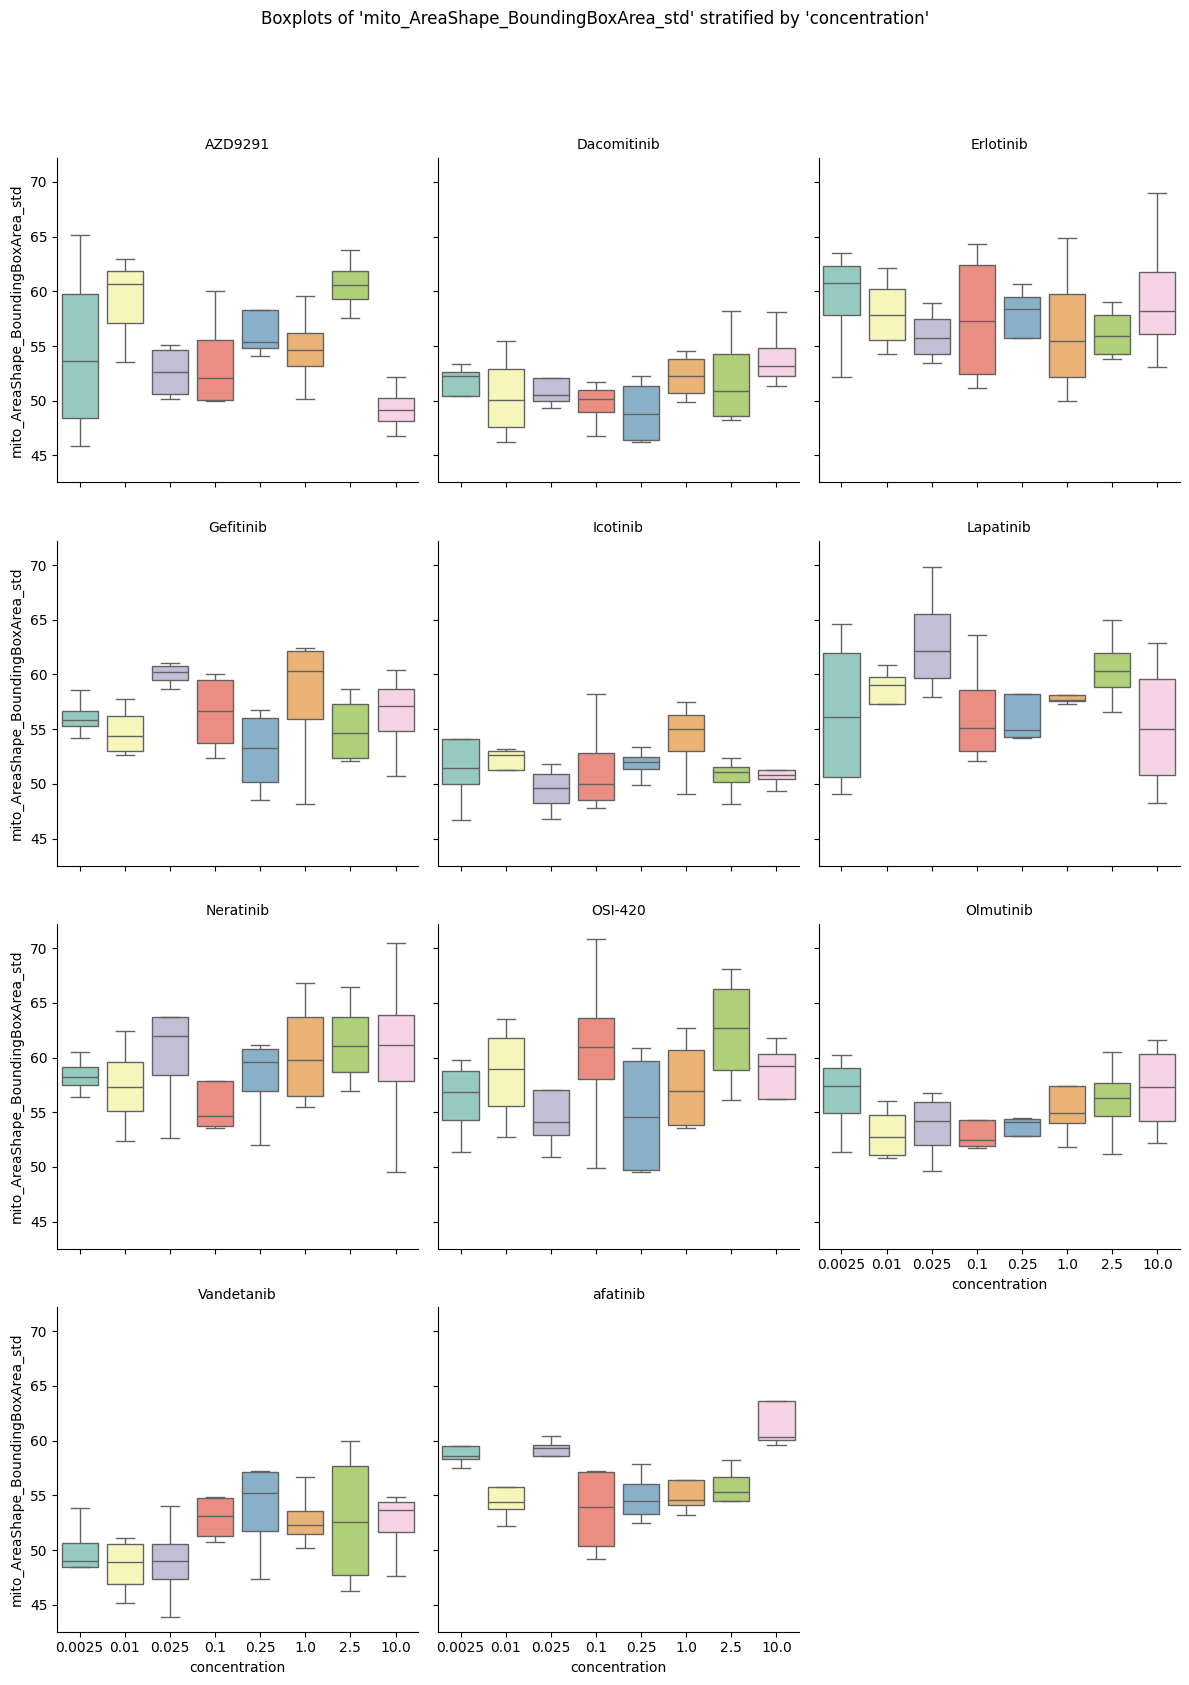

/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-pac

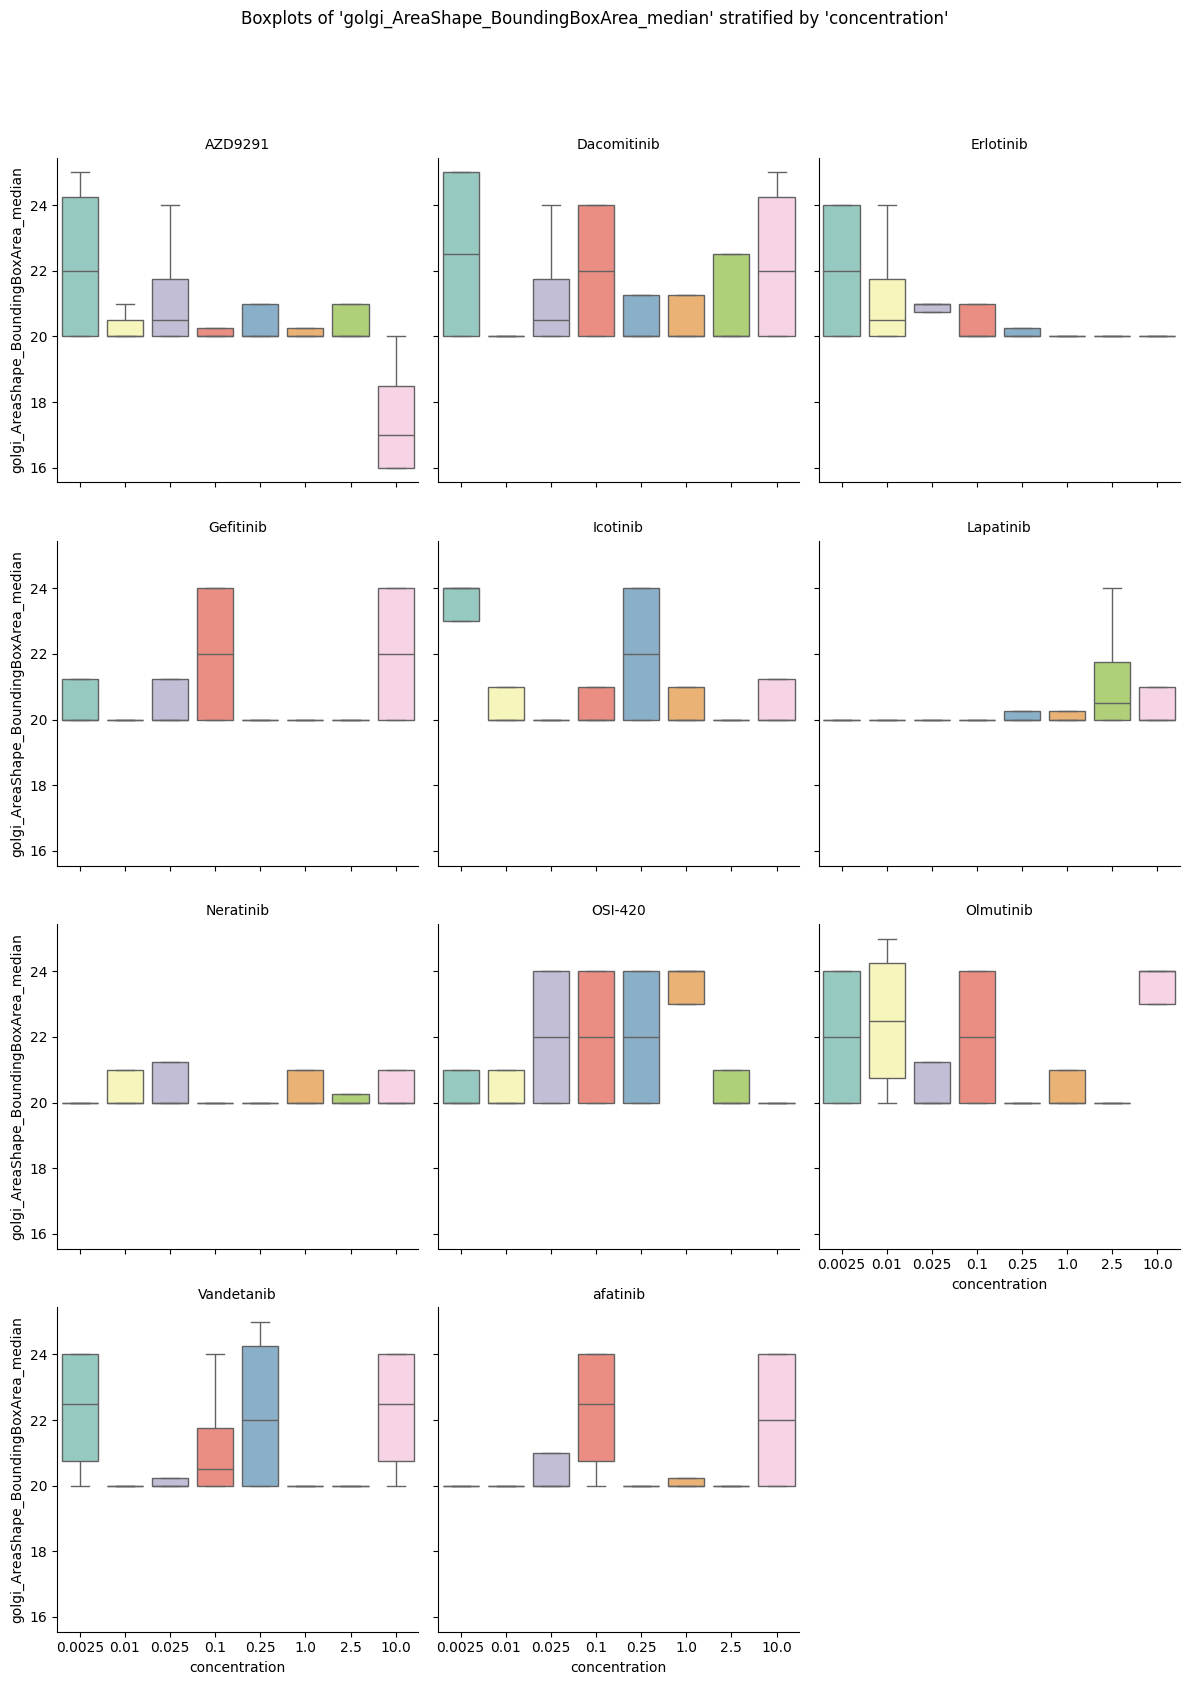

/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/aru/Development/morphologic/.venv/lib/python3.11/site-pac

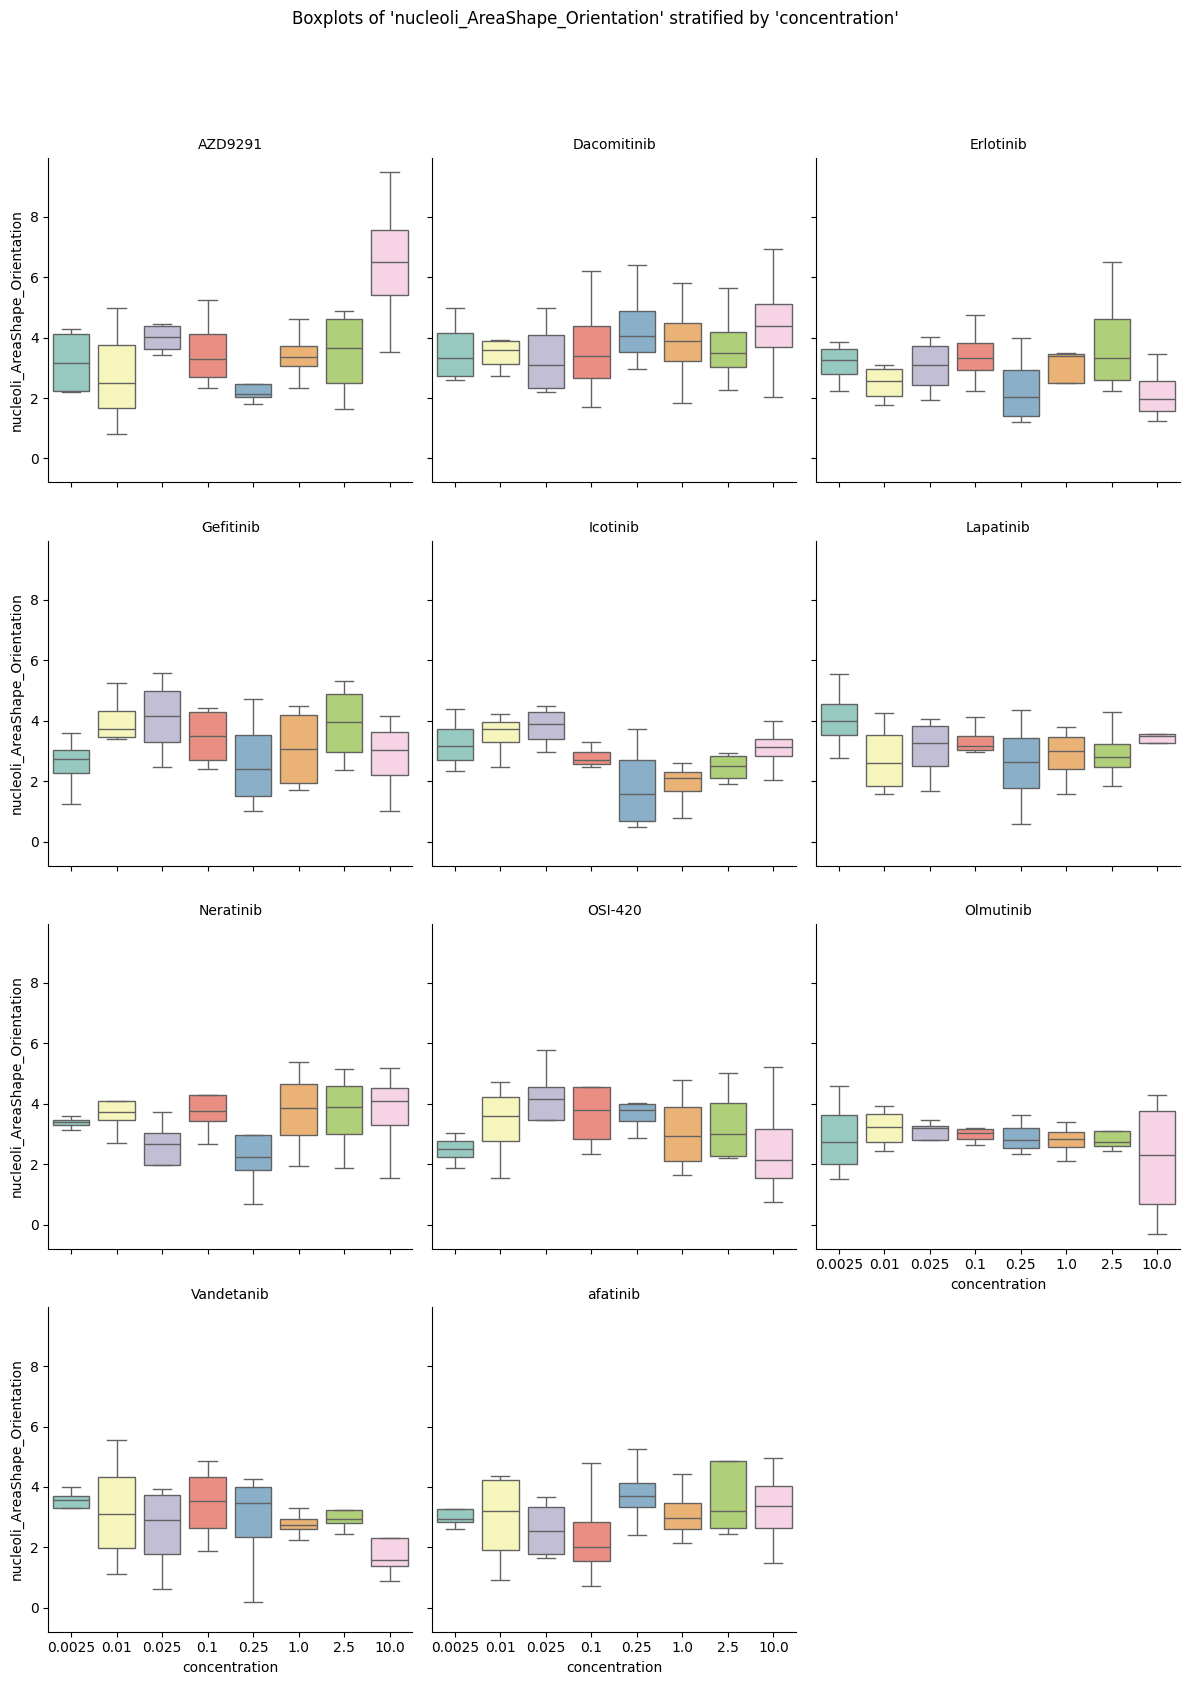

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplots_by_group_facet(adata, var_name, group_by, stratify_by, col_wrap=3):
    """
    Create subplots for boxplots of a specific feature across groups, stratified by another variable.

    Parameters:
        adata (AnnData): Input AnnData object.
        var_name (str): Feature name to plot.
        group_by (str): Column name in adata.obs to create subplots for each unique value.
        stratify_by (str): Column name in adata.obs to stratify the boxplot within each subplot.
        col_wrap (int): Number of columns for subplot grid. Defaults to 2.

    Returns:
        None
    """
    # ensure the grouping column exists
    if group_by not in adata.obs.columns:
        raise ValueError(f"'{group_by}' not found in adata.obs.")

    # ensure the stratification column exists
    if stratify_by not in adata.obs.columns:
        raise ValueError(f"'{stratify_by}' not found in adata.obs.")

    # ensure the feature exists
    if var_name not in adata.var_names:
        raise ValueError(f"'{var_name}' not found in adata.var_names.")

    # create a dataframe with necessary data
    data = pd.DataFrame({
        group_by: adata.obs[group_by],
        stratify_by: adata.obs[stratify_by],
        var_name: adata[:, var_name].X.flatten(),
    })

    # create a facet grid for boxplots
    g = sns.FacetGrid(data, col=group_by, col_wrap=col_wrap, height=4, sharey=True)
    g.map_dataframe(
        sns.boxplot,
        x=stratify_by,
        y=var_name,
        palette="Set3",
        showfliers=False,
    )
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels(stratify_by, var_name)
    g.fig.suptitle(f"Boxplots of '{var_name}' stratified by '{stratify_by}'", y=1.05)
    g.tight_layout()
    plt.show()


for feature_name in fs.drop_duplicates(subset=['compartment'], keep='first')['feature_name']:
    plot_boxplots_by_group_facet(cp_adata[~cp_adata.obs['concentration'].isna(), :], feature_name, "treatment", "concentration")


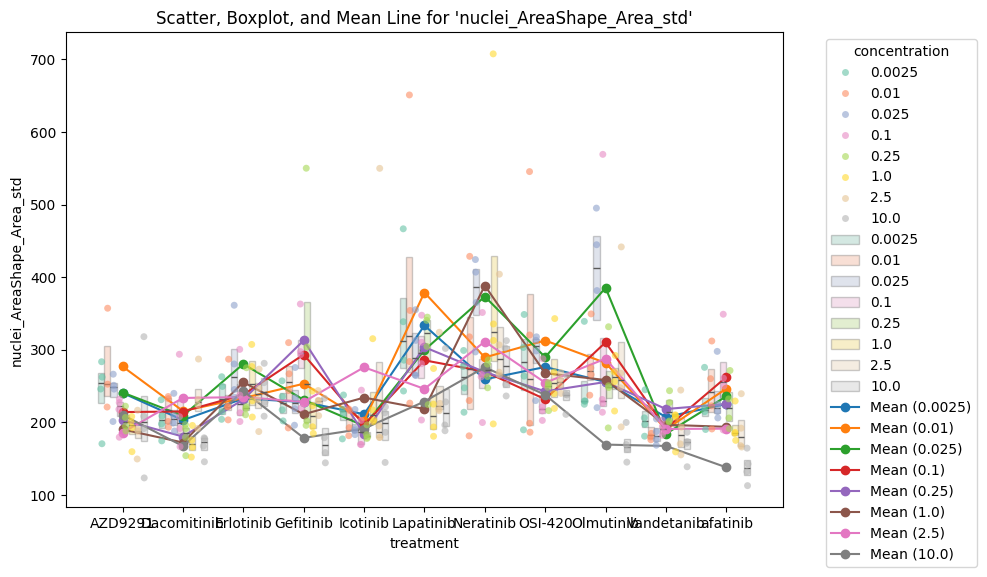

In [104]:
def plot_points_with_box_and_mean_line(
    adata, var_name, x_axis, stratify_by, line_fit=True, figsize=(10, 6)
):
    """
    Plot points, boxplot, and mean/variance line for a given feature across a variable on the x-axis.

    Parameters:
        adata (AnnData): Input AnnData object.
        var_name (str): Feature name to plot.
        x_axis (str): Column name in adata.obs for the x-axis grouping.
        stratify_by (str): Column name in adata.obs to stratify colors of the points.
        line_fit (bool): Whether to fit a line to the mean values. Defaults to True.
        figsize (tuple): Figure size for the plot. Defaults to (10, 6).

    Returns:
        None
    """
    if x_axis not in adata.obs.columns:
        raise ValueError(f"'{x_axis}' not found in adata.obs.")

    if stratify_by not in adata.obs.columns:
        raise ValueError(f"'{stratify_by}' not found in adata.obs.")

    if var_name not in adata.var_names:
        raise ValueError(f"'{var_name}' not found in adata.var_names.")

    # filter out rows with NaN in relevant columns
    valid_obs_mask = ~adata.obs[[x_axis, stratify_by]].isnull().any(axis=1)
    filtered_adata = adata[valid_obs_mask].copy()

    # create a dataframe for seaborn
    data = pd.DataFrame({
        x_axis: filtered_adata.obs[x_axis],
        stratify_by: filtered_adata.obs[stratify_by],
        var_name: filtered_adata[:, var_name].X.flatten(),
    })

    # initialize the figure
    plt.figure(figsize=figsize)

    # plot jittered points
    sns.stripplot(
        data=data,
        x=x_axis,
        y=var_name,
        hue=stratify_by,
        dodge=True,
        alpha=0.6,
        jitter=True,
        palette="Set2",
        marker="o",
    )

    # overlay boxplots
    sns.boxplot(
        data=data,
        x=x_axis,
        y=var_name,
        hue=stratify_by,
        dodge=True,
        showcaps=False,
        boxprops=dict(alpha=0.3),
        showfliers=False,
        whiskerprops=dict(linewidth=0),
        palette="Set2",
    )

    # calculate means and variances for line fitting
    if line_fit:
        group_means = data.groupby([x_axis, stratify_by])[var_name].mean().reset_index()
        group_vars = data.groupby([x_axis, stratify_by])[var_name].var().reset_index()

        for category in group_means[stratify_by].unique():
            category_means = group_means[group_means[stratify_by] == category]
            plt.plot(
                category_means[x_axis],
                category_means[var_name],
                marker="o",
                linestyle="-",
                label=f"Mean ({category})",
            )

    # configure legend and labels
    plt.legend(title=stratify_by, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title(f"Scatter, Boxplot, and Mean Line for '{var_name}'")
    plt.xlabel(x_axis)
    plt.ylabel(var_name)
    plt.tight_layout()
    plt.show()

plot_points_with_box_and_mean_line(cp_adata, "nuclei_AreaShape_Area_std", "treatment", "concentration")


In [169]:
compound_empty_control_wellids = cp_adata[((cp_adata.obs['perturbation_type'] == 'COMPOUND') & (cp_adata.obs['treatment'] == 'EMPTY_control')), :].obs_names  # Compound EMPTY_control
egfrko_empty_control_wellids = cp_adata[((cp_adata.obs['perturbation_type'] == 'CRISPR') & (cp_adata.obs['treatment'] == 'EMPTY_control')), :].obs_names  # CRISPR EGFR-KO EMPTY_control
egfrko_well_ids = cp_adata[((cp_adata.obs['perturbation_type'] == 'CRISPR') & (cp_adata.obs['treatment'] != 'EMPTY_control')), :].obs_names  # CRISPR EGFR-KO


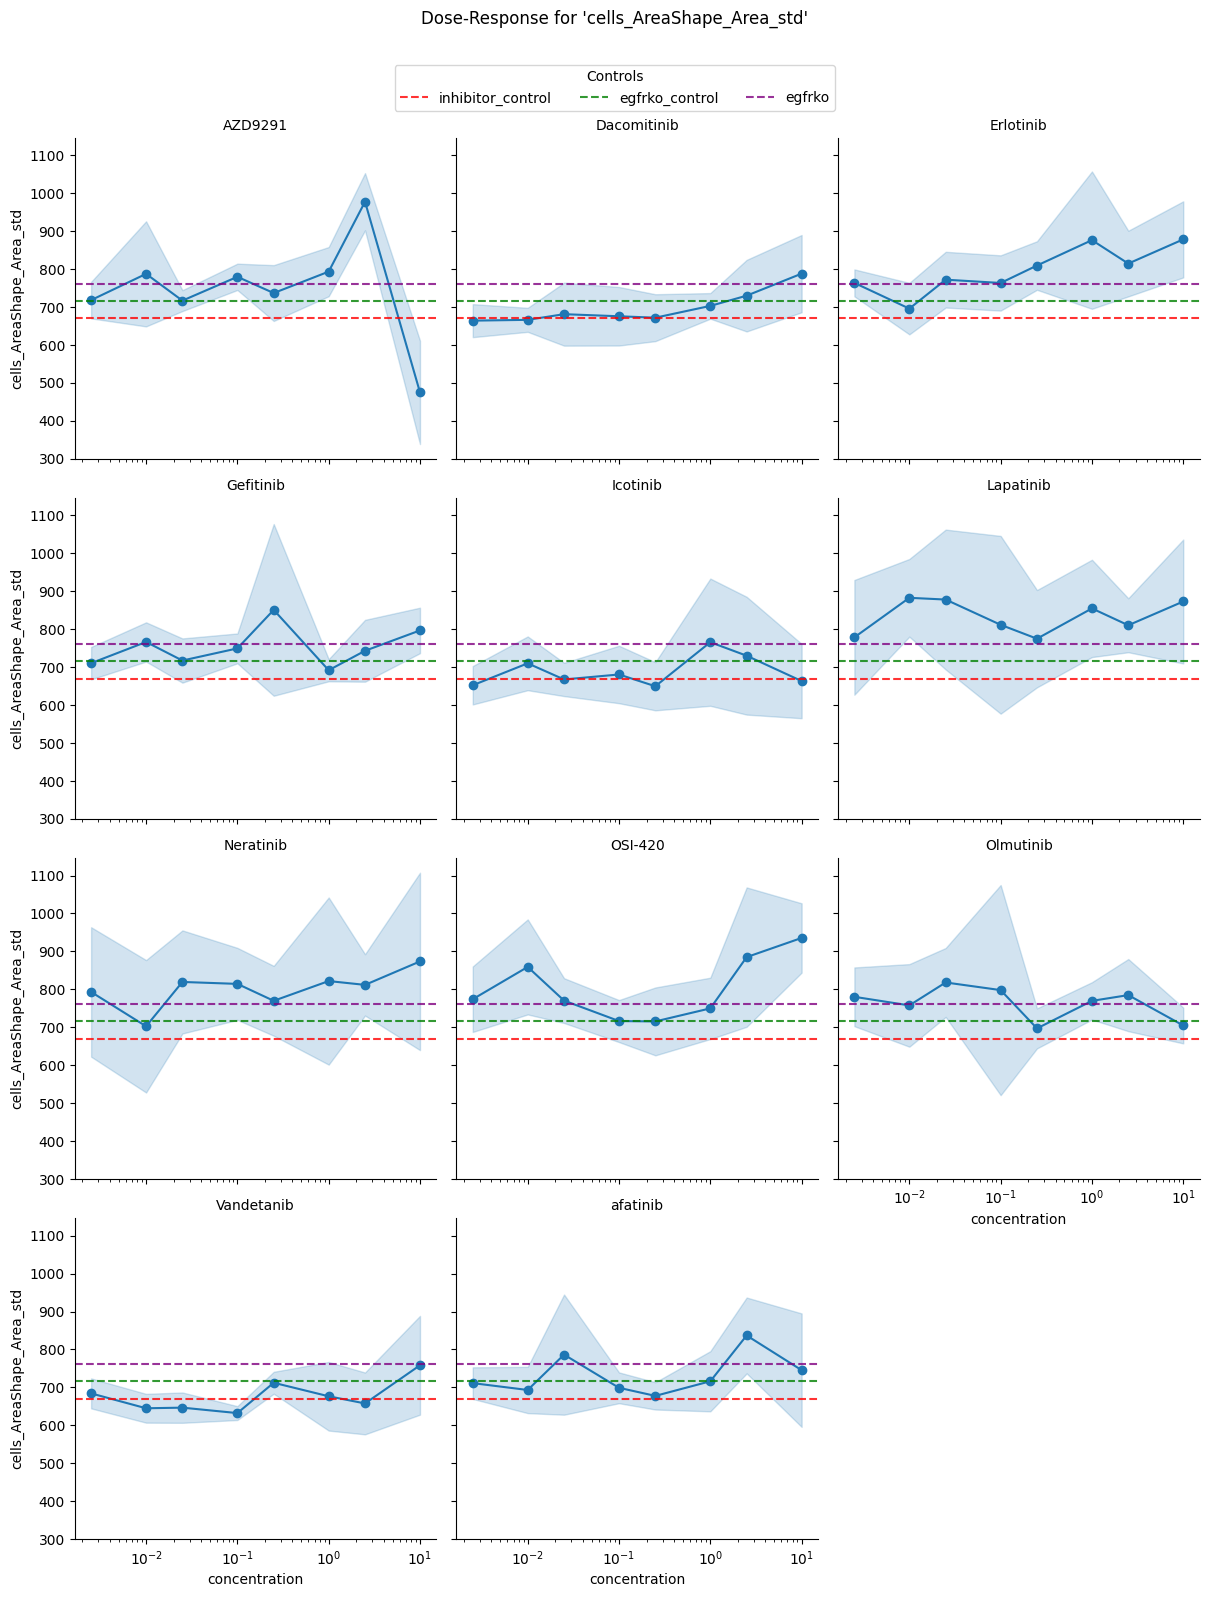

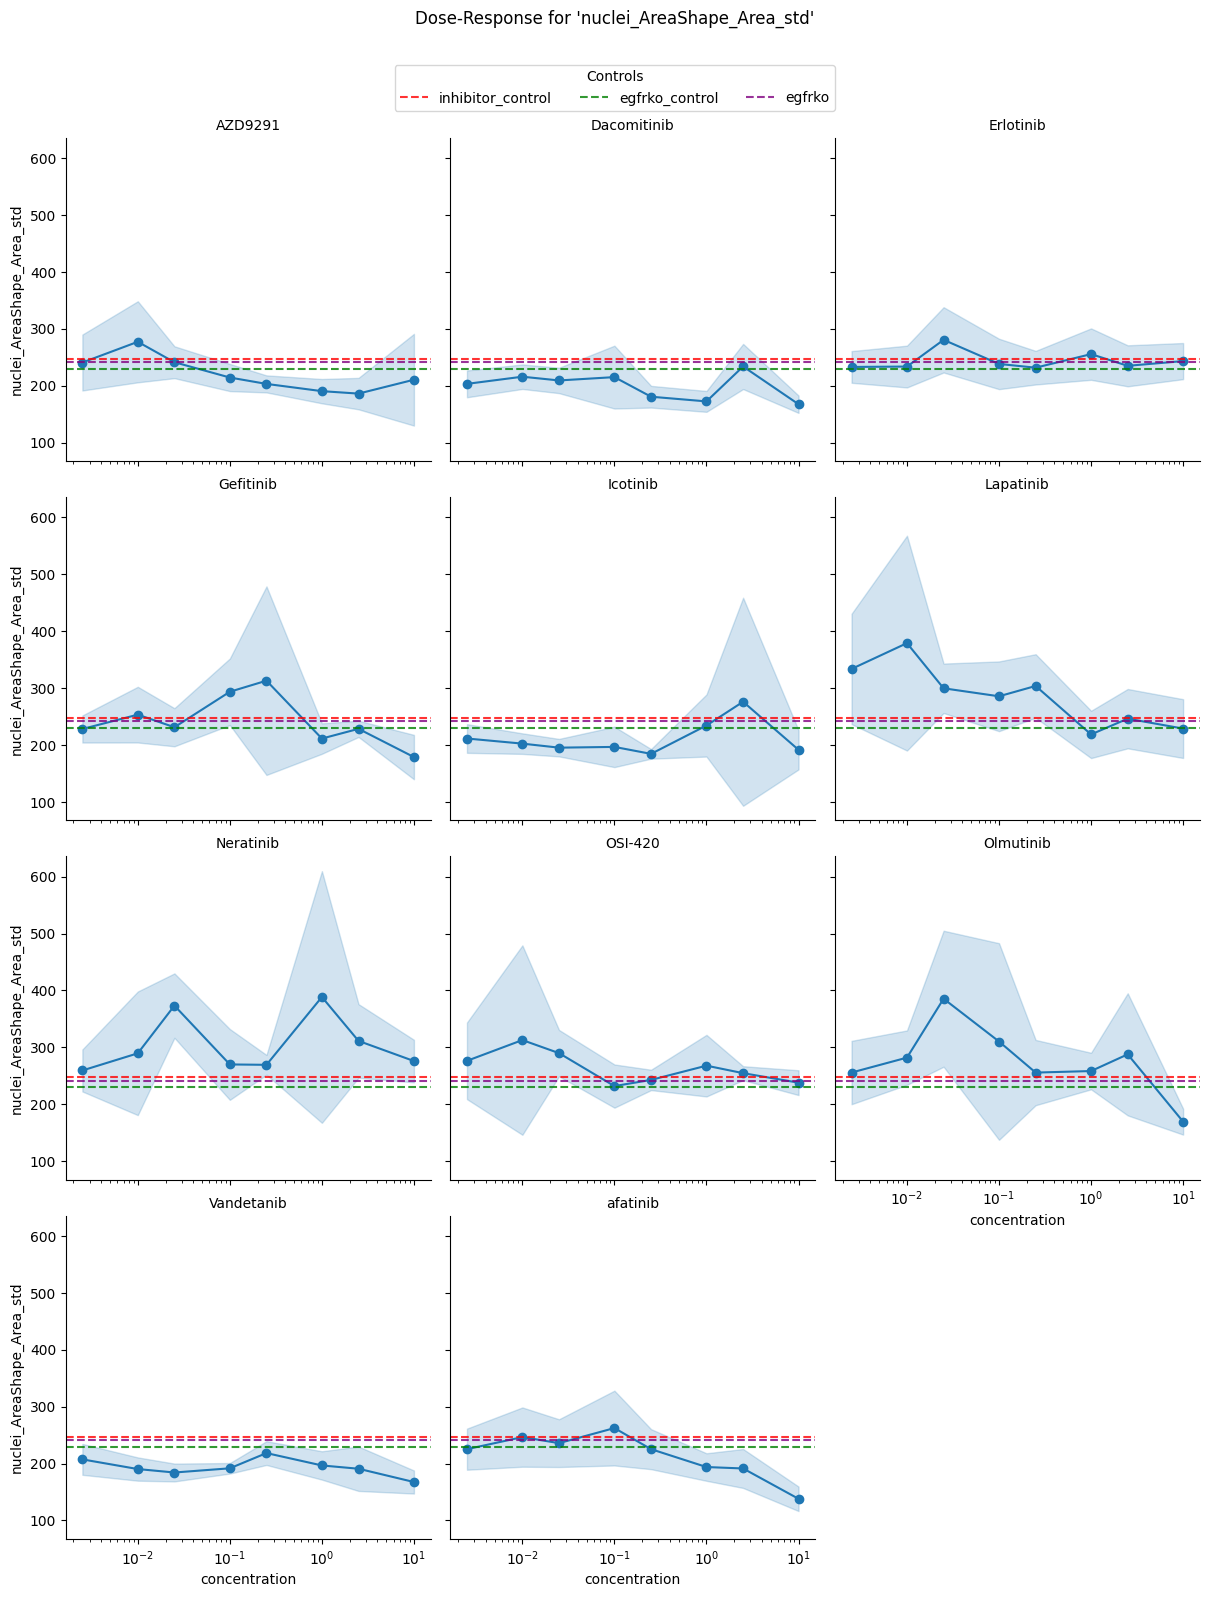

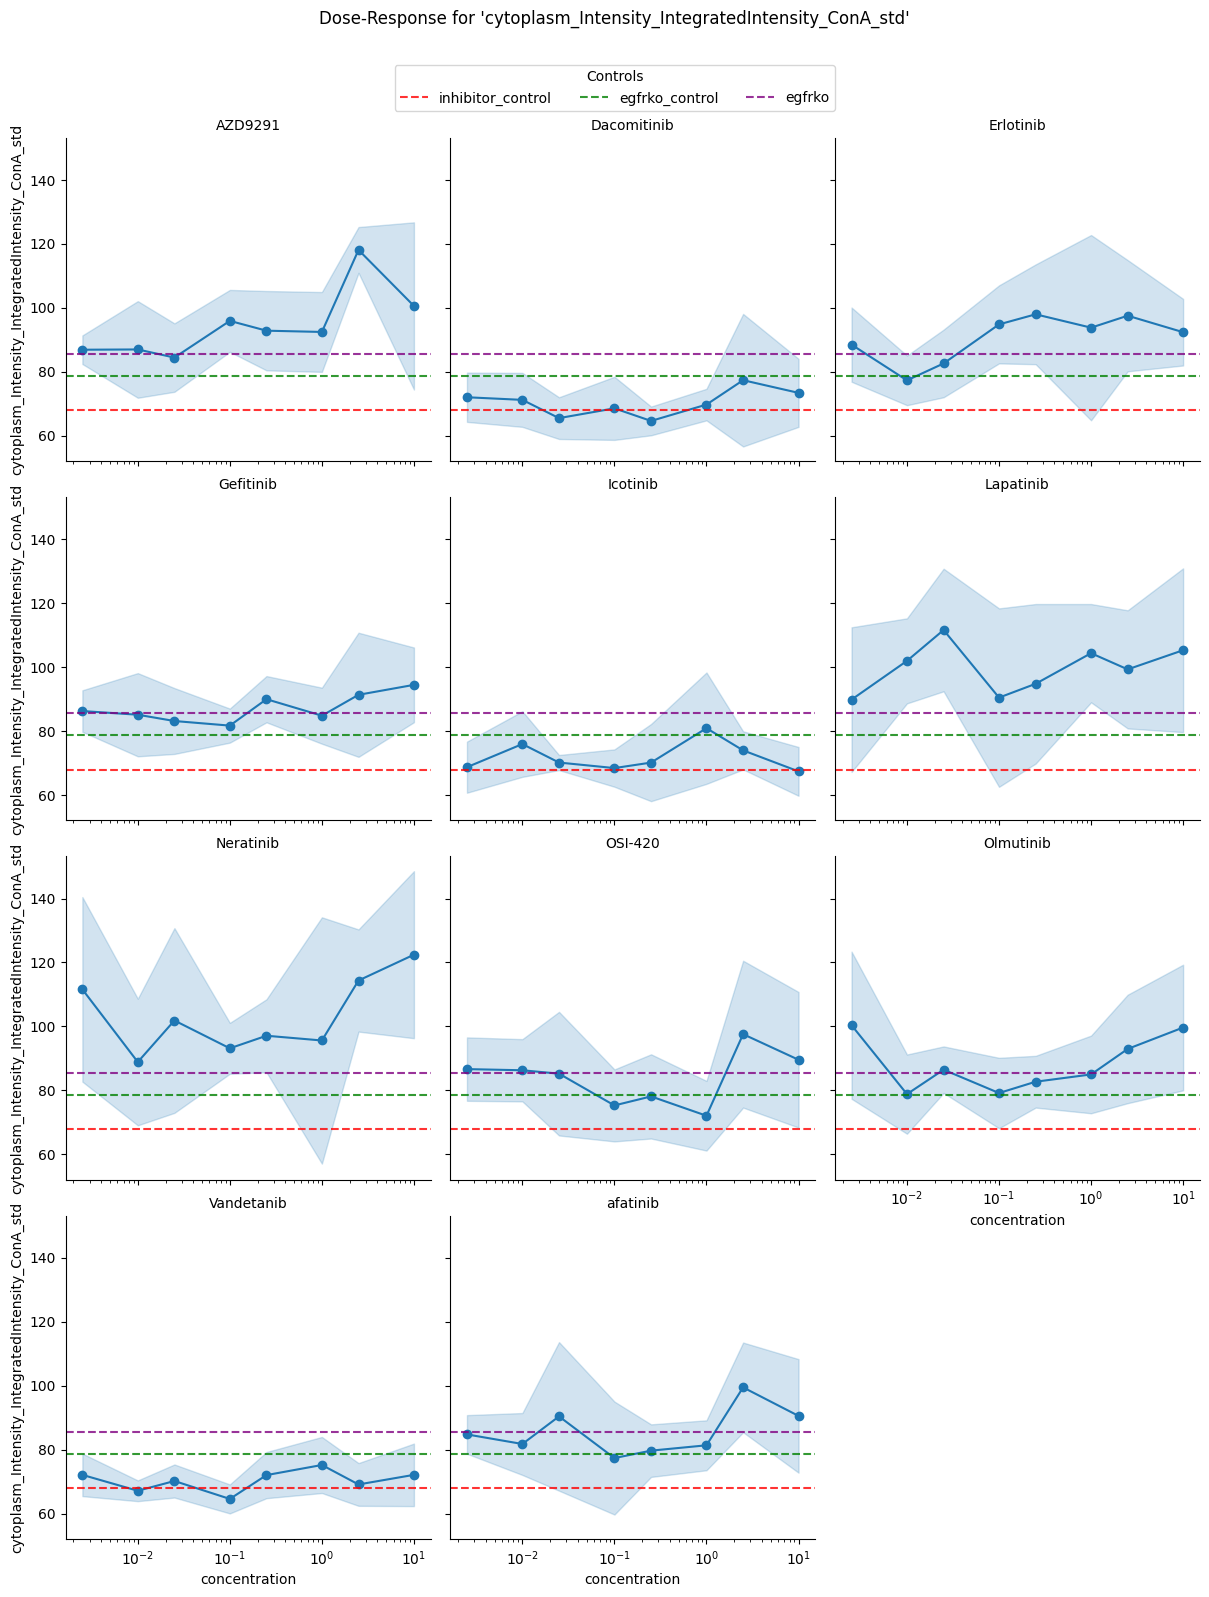

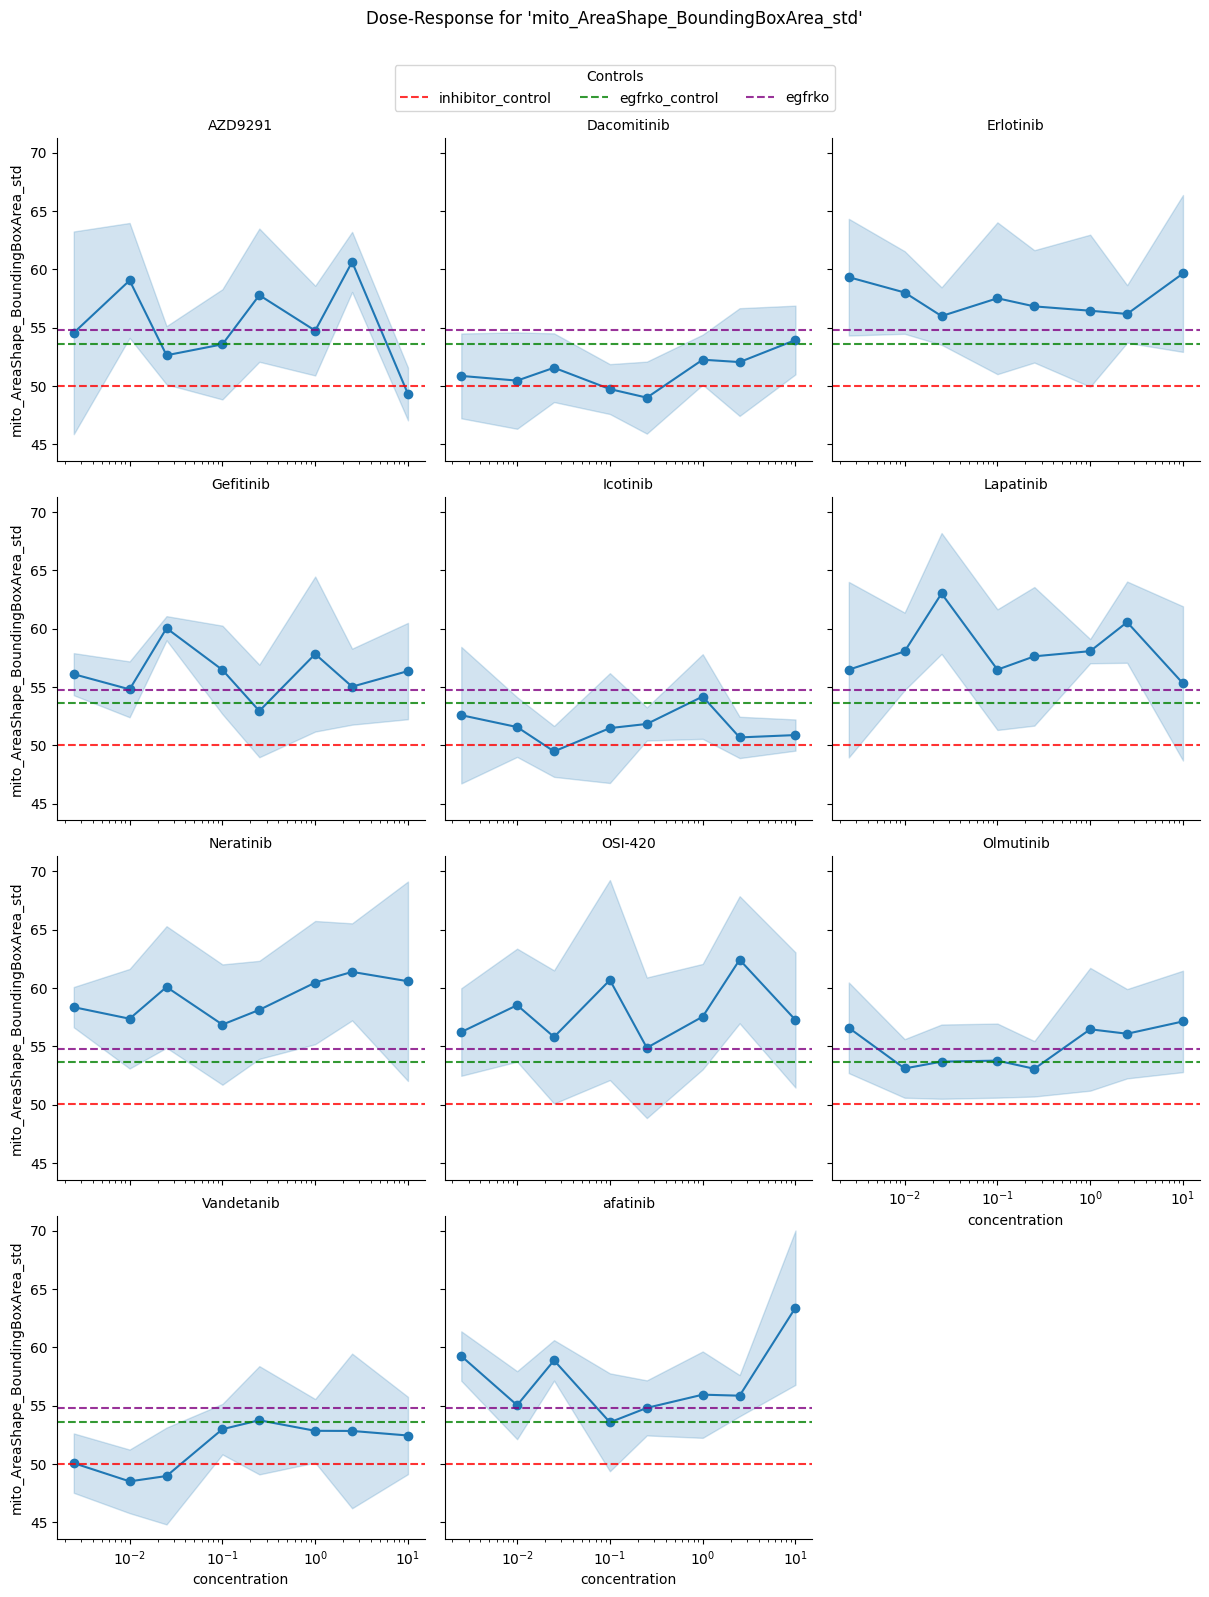

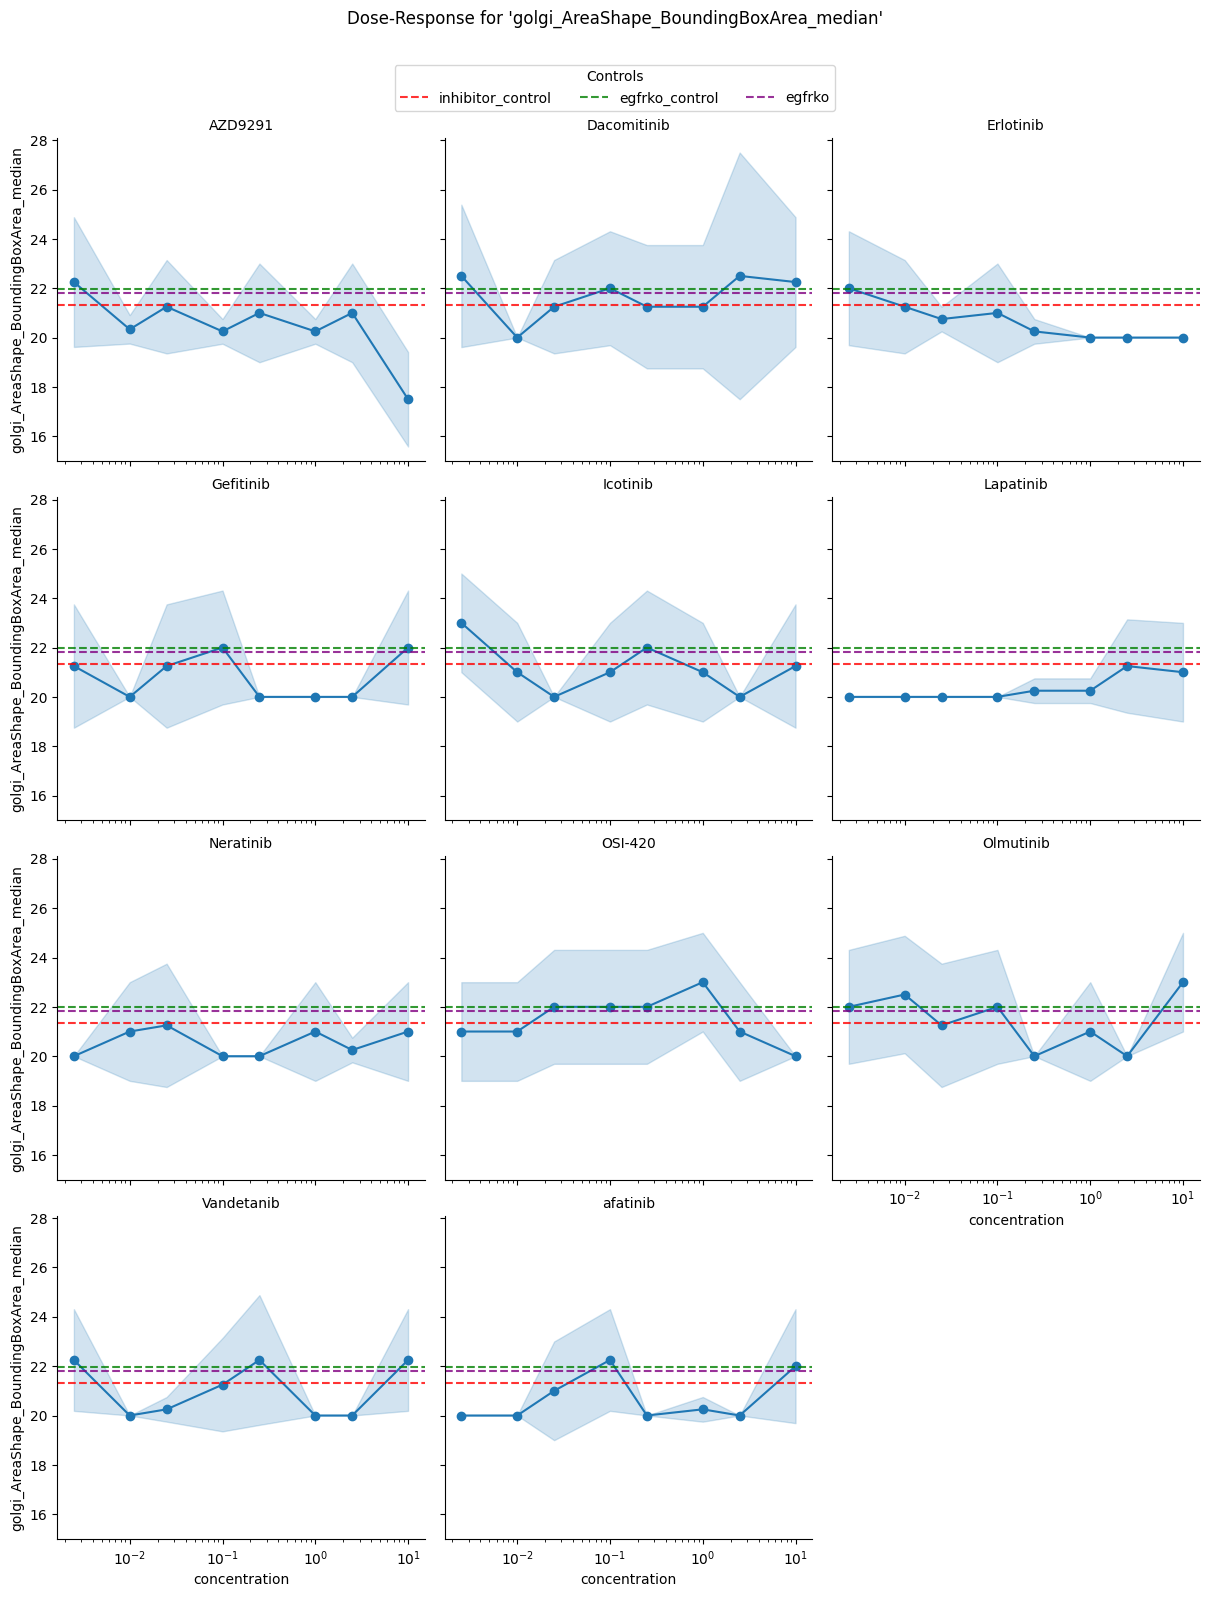

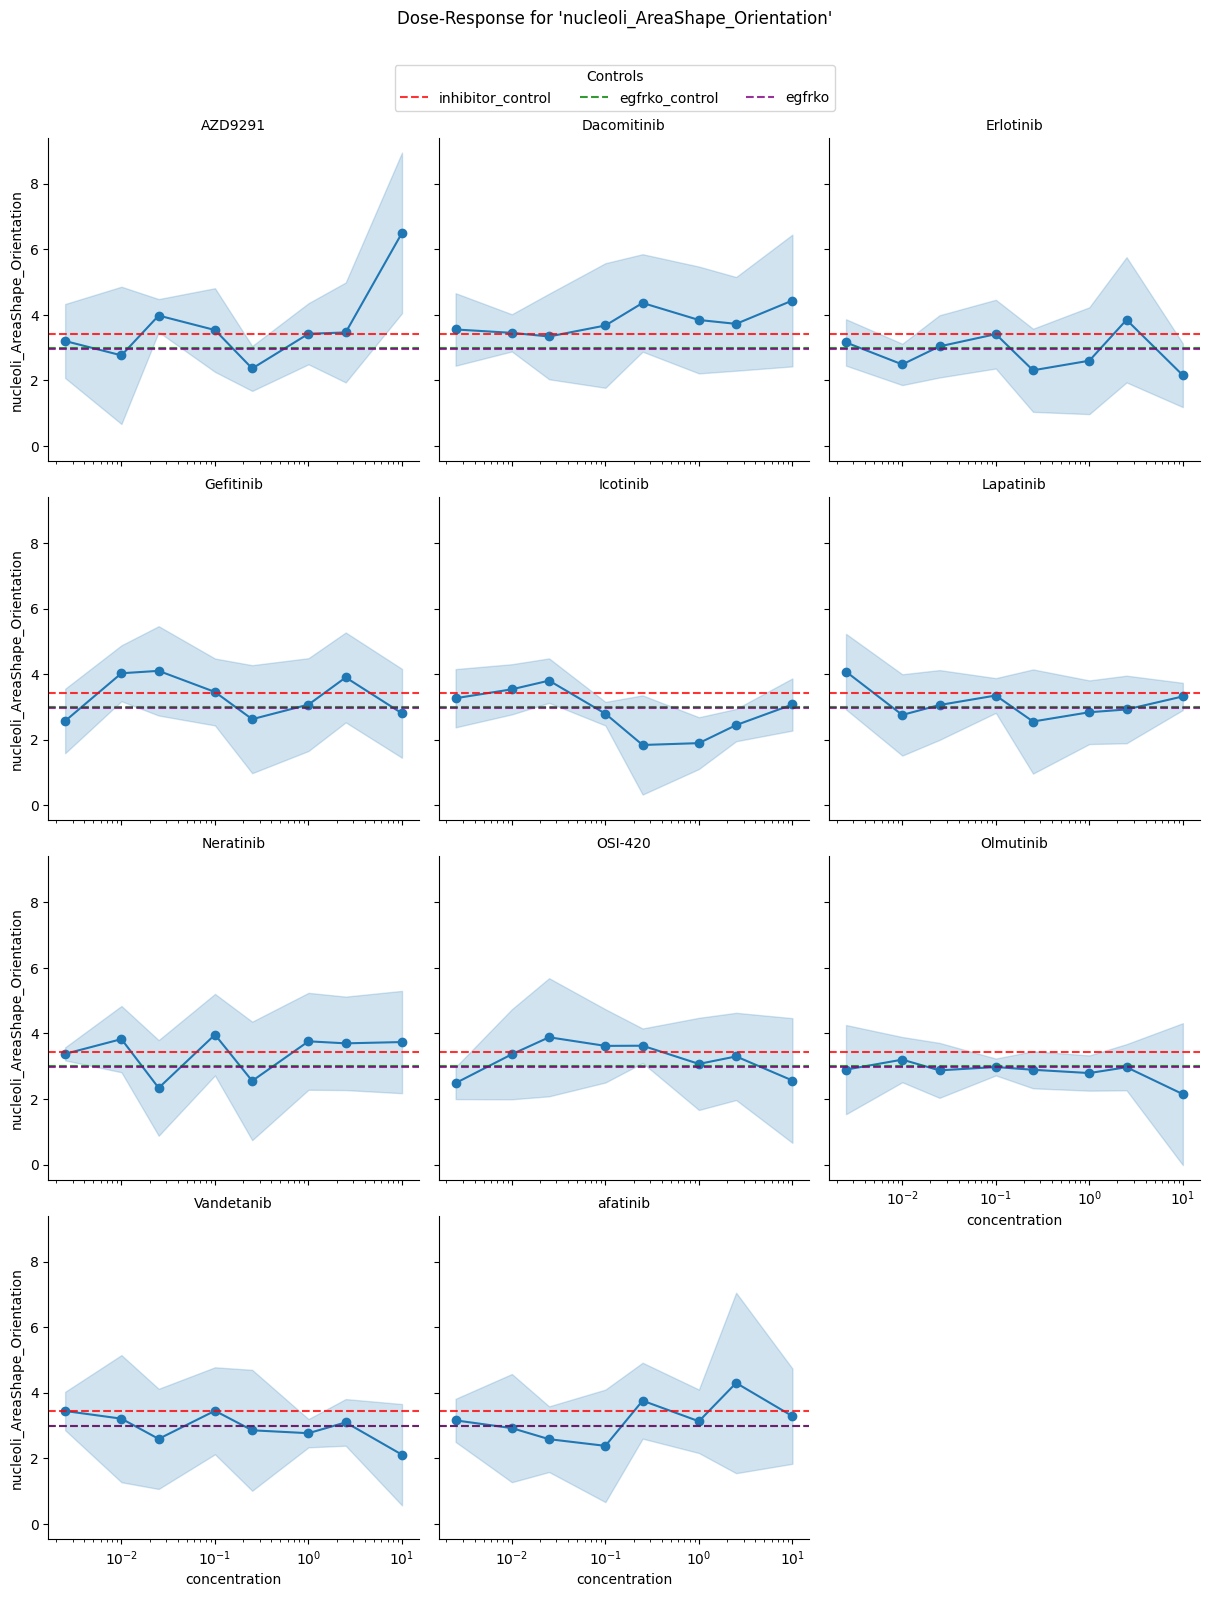

In [194]:
from utils import plot_dose_response

for feature_name in fs.drop_duplicates(subset=['compartment'], keep='first')['feature_name']:

    plot_dose_response(
        adata=cp_adata,
        var_name=feature_name,
        x_axis="concentration",
        stratify_by="treatment",
        log_scale=True,
        compound_empty_control_ids=compound_empty_control_wellids,
        egfrko_empty_control_ids=egfrko_empty_control_wellids,
        egfrko_nonempty_control_ids=egfrko_well_ids,
    )


In [178]:
egfrko_well_ids

Index(['gene-081_5_B14', 'gene-081_6_O39', 'gene-081_9_W42', 'gene-081_8_AC31',
       'gene-081_7_Y17', 'gene-081_2_AA16', 'gene-081_5_F35', 'gene-081_4_R41',
       'gene-081_8_H38', 'gene-081_7_C47',
       ...
       'gene-157_7_C10', 'gene-157_3_AC22', 'gene-157_9_Y16', 'gene-157_5_F41',
       'gene-157_2_AC41', 'gene-157_1_AA42', 'gene-157_2_P08',
       'gene-157_9_N20', 'gene-157_8_AC24', 'gene-157_7_T29'],
      dtype='object', name='well_id', length=105)

# Run and plot PCA

We see a dud, remove it


In [ ]:
from utils import clean_adata, run_pca, plot_dim_reduction

# RXRX
run_pca(crispr_rxrx_adata)
plot_dim_reduction(
    crispr_rxrx_adata, 
    basis='X_pca', 
    color_by='treatment',
    style_by='experiment_name',
    dims=[0, 1], 
    title='PCA of RXRX3 Embeddings (EGFR-KO)'
)

# CellProfiler
crispr_cp_adata = clean_adata(crispr_cp_adata, standardize=False)

# print cleaning info:
print(f"rows dropped: {crispr_cp_adata.uns['cleaning_info']['n_rows_dropped']}")
print(f"columns dropped: {crispr_cp_adata.uns['cleaning_info']['n_cols_dropped']}")

run_pca(crispr_cp_adata)
plot_dim_reduction(
    crispr_cp_adata, 
    basis='X_pca', 
    color_by='treatment',
    style_by='experiment_name',
    dims=[0, 1], 
    title='PCA of CellProfiler Embeddings (EGFR-KO)'
)

In [ ]:
from utils import compute_r2_scores

# RXRX3
r2_rxrx_batch = compute_r2_scores(crispr_rxrx_adata, "experiment_name")
print("RXRX3 Batch R²:", r2_rxrx_batch[:5])

# CellProfiler
r2_cp_batch = compute_r2_scores(crispr_cp_adata, "experiment_name")
print("CP Batch R²:", r2_cp_batch[:5])


In [ ]:
plot_dim_reduction(
    crispr_cp_adata,
    basis='X_pca',
    color_by='experiment_name',
    dims=[0, 1],  # PC1 vs PC2
    title='PCA of CP Embeddings (Colored by Batch)'
)


In [ ]:
from utils import combat_correct

crispr_cp_adata_combat = crispr_cp_adata.copy()
combat_correct(crispr_cp_adata_combat, batch_key="experiment_name")
run_pca(crispr_cp_adata_combat)

plot_dim_reduction(
    crispr_cp_adata_combat,
    basis='X_pca',
    color_by='treatment',
    style_by='experiment_name',
    dims=[0, 1],
    title='PCA of CP Features (Batch-Corrected)'
)


In [ ]:
import harmonypy as hm

crispr_cp_adata_harmony = crispr_cp_adata.copy()
ho = hm.run_harmony(crispr_cp_adata_harmony.X, crispr_cp_adata_harmony.obs, "experiment_name")
crispr_cp_adata_harmony.obsm["X_pca"] = ho.Z_corr.T

plot_dim_reduction(
    crispr_cp_adata_harmony,
    basis='X_pca',
    color_by='treatment',
    style_by='experiment_name',
    dims=[0, 1],
    title='PCA of CP Features (Harmony-Corrected)'
)


# We see experiment as a batch effect.

In [ ]:
_adata = get_crispr_perturbations(crispr_cp_adata).copy()
run_pca(_adata)
plot_dim_reduction(
    adata=_adata, 
    basis='X_pca', 
    style_by='experiment_name',
    color_by='treatment',
    dims=[0, 1], 
    title='PCA of CellProfiler Embeddings (EGFR-KO, cleaned CP)'
)


# Remove the low-variance and highly correlated features

In [ ]:
from utils import (
    select_features,
    clean_adata,
    combat_correct,
    compute_r2_scores,
    plot_r2_scores,
)

# Step 1: Clean the data
_adata_raw = clean_adata(get_crispr_perturbations(cp_adata), standardize=False).copy()

# Step 2: Perform initial PCA and visualization
run_pca(_adata_raw)
plot_dim_reduction(
    adata=_adata_raw,
    basis="X_pca",
    style_by="treatment",
    color_by="experiment_name",
    dims=[0, 1],
    title="PCA of CellProfiler Embeddings (EGFR-KO, cleaned CP)",
)

# Step 3: Feature selection
features, stats = select_features(
    adata=_adata_raw, 
    variance_threshold=0.05,
    correlation_threshold=0.8,
    target_col="gene"
)
_adata_filtered = _adata_raw[:, features]

# Step 4: Re-run PCA after feature selection
run_pca(_adata)
plot_dim_reduction(
    adata=_adata_filtered,
    basis="X_pca",
    style_by="treatment",
    color_by="experiment_name",
    dims=[0, 1],
    title="PCA of CellProfiler Embeddings (EGFR-KO, cleaned CP, filtered features)",
)

# Step 5: Apply ComBat for batch correction
combat_correct(_adata_filtered, batch_key="experiment_name", covariates=["treatment"])

# Step 6: Re-run PCA after ComBat
run_pca(_adata_filtered)
plot_dim_reduction(
    adata=_adata_filtered,
    basis="X_pca",
    style_by="treatment",
    color_by="experiment_name",
    dims=[0, 1],
    title="PCA of CellProfiler Embeddings (EGFR-KO, cleaned CP, filtered features, ComBat corrected)",
)

# Step 7: Compute and visualize R² scores before and after batch correction
r2_scores_before = compute_r2_scores(_adata_raw, "experiment_name")
r2_scores_after = compute_r2_scores(_adata_filtered, "experiment_name")
plot_r2_scores(r2_scores_before=r2_scores_before, r2_scores_after=r2_scores_after)


In [ ]:
from utils import (
    clean_adata,
    combat_correct,
    select_features,
    run_pca,
    plot_dim_reduction,
    compute_r2_scores,
    plot_r2_scores,
)

# Step 1: Clean the data
_adata_cp = crispr_cp_adata.copy()
_adata_cp_raw = crispr_cp_adata.copy()

# Step 2: Batch correction (ComBat or Harmony)
combat_correct(_adata_cp, batch_key="experiment_name", covariates=["treatment"])

# Step 3: Standardize features
from sklearn.preprocessing import StandardScaler
_adata_cp.X = StandardScaler().fit_transform(_adata_cp.X)

# Step 4: Feature selection
features, stats = select_features(
    adata=_adata_cp,
    variance_threshold=0.1,
    correlation_threshold=0.8,
    target_col="treatment"
)
_adata_cp = _adata_cp[:, features]
_adata_cp_raw = _adata_cp_raw[:, features]

# Step 5: PCA on CP features
run_pca(_adata_cp)
run_pca(_adata_cp_raw)
plot_dim_reduction(
    adata=_adata_cp,
    basis="X_pca",
    color_by="treatment",
    style_by="experiment_name",
    dims=[0, 1],
    title="PCA of CP Features (Batch-Corrected)"
)

# Step 7: Compute and visualize R² scores before and after batch correction
r2_scores_before = compute_r2_scores(_adata_cp_raw, "experiment_name")
r2_scores_after = compute_r2_scores(_adata_cp, "experiment_name")
plot_r2_scores(r2_scores_before=r2_scores_before, r2_scores_after=r2_scores_after)


In [ ]:
# Run harmony
import harmonypy as hm

# Combine batch and covariates into a single column (optional)
_adata_cp.obs["batch_covariate"] = (
    _adata_cp.obs["experiment_name"].astype(str) + "_" + _adata_cp.obs["treatment"].astype(str)
)

# Run harmony
ho = hm.run_harmony(
    _adata_cp.X,
    _adata_cp.obs,
    "experiment_name"  # Specify batch key directly
)
_adata_cp.obsm["X_pca"] = ho.Z_corr.T  # Corrected embeddings from Harmony


run_pca(_adata_cp)
plot_dim_reduction(
    adata=_adata_cp,
    basis="X_pca",
    color_by="treatment",
    style_by="experiment_name",
    dims=[0, 1],
    title="PCA of CP Features (Harmony-Corrected)"
)


r2_scores_after = compute_r2_scores(_adata_cp, "experiment_name")
plot_r2_scores(r2_scores_before=r2_scores_before, r2_scores_after=r2_scores_after)


In [ ]:
# Step 1: Load recursion embeddings into AnnData format
_adata_recursion = crispr_rxrx_adata.copy()

# Step 2: Standardize recursion embeddings
_adata_recursion.X = StandardScaler().fit_transform(_adata_recursion.X)

# Step 3: PCA on recursion embeddings
run_pca(_adata_recursion)
plot_dim_reduction(
    adata=_adata_recursion,
    basis="X_pca",
    color_by="treatment",
    style_by="experiment_name",
    dims=[0, 1],
    title="PCA of Recursion Embeddings"
)


In [ ]:
cellprofiler_adata.var_names.str.split('_').str[0].unique()

In [ ]:
# First, let's clean the data before normalization
# Replace inf with NaN and then fill with median
X_clean = cellprofiler_adata.X.copy()
X_clean = np.where(np.isinf(X_clean), np.nan, X_clean)

# For Form Factor specifically, clip to reasonable range
form_factor_mask = [('FormFactor' in name) for name in cellprofiler_adata.var_names]
if np.any(form_factor_mask):
    X_clean[:, form_factor_mask] = np.clip(X_clean[:, form_factor_mask], 0, 1)

# Fill remaining NaN with median
for col in range(X_clean.shape[1]):
    col_median = np.nanmedian(X_clean[:, col])
    X_clean[np.isnan(X_clean[:, col]), col] = col_median

# Create cleaned AnnData
adata_clean = cellprofiler_adata.copy()
adata_clean.X = X_clean

# Now normalize as before
normalizer = AnnDataNormalizer(method='mad')
normalized_adata = normalizer.fit_transform(adata_clean)